# Deep Learning for chemistry
This weeks task is structured around the 2018 Nomad challenge on Kaggle, an online machine learning platform wiht many tutorial and open data science competitions. For this we require several deep learning and data science libraries as well as the dataset from the competition, containing the data of 2400 $(Al_xGa_yIn_z)_2O_3$ crystals.

In [1]:
!pip install --upgrade pip
!pip install pandas
!pip install seaborn
!pip install tensorflow
!pip install keras
!pip install scikit-learn
!pip install ase

The dataset can be cloned from a github repository. 

In [ ]:
!git clone https://github.com/csutton7/nomad_2018_kaggle_dataset.git

Know we want to import all relevant modules: 
* Seaborn and pandas provide functionalities for the manipulation and visualization of large datasets
* Kears provides neural network functions as a wrapper for Tensorflow
* SKlearn is a machine learning library with several important functionalities
* Atomic simulation environment (ASE) is a chemistry package which allows you to easily load and manipulate chemichal data

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import keras
from sklearn.kernel_ridge import KernelRidge

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from ase.geometry import Cell
from ase.io.aims import read_aims

As a first step, we have to load our data. Fortunately, we can use Pandas to directly load the data from a .csv file as a dataframe.

In [63]:
train_df = pd.read_csv("train.csv")

How does our data look like? As you can see, we loaded strctural parameters of crystal structures together with the formation energy and the bandgap values of several semiconductors.

In [64]:
train_df.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


At this point, input and output is combinded in this dataset. Thus, we have to divide the features into input features, which are used as an input for the model and have to be known beforehand, and output features, which are the target of our model. 

In [65]:
#Pull out Targets for later
Targets_df=pd.DataFrame()
Targets_df["bandgap_energy_ev"] = train_df["bandgap_energy_ev"].copy()
Targets_df["formation_energy_ev_natom"] = train_df["formation_energy_ev_natom"].copy()
train_df=train_df.drop(["formation_energy_ev_natom","bandgap_energy_ev"],axis=1) 
train_df=train_df.drop(["id"],axis=1)
Targets_df.head()

,bandgap_energy_ev,formation_energy_ev_natom
0,3.4387,0.0680
1,2.9210,0.2490
2,2.7438,0.1821
3,3.3492,0.2172
4,1.3793,0.0505


Our input data contains very different parameter, both in type and value. Thus, we have to think about how we present this data in the most informative way to our model before anything else. A typical approach in data preprocessing is to transform the data by e.g. using a relative value instead of absoulte quantities. Furthermore, categorical data like the spacegroup can be cast into a much more powerful representation by using a "one-hot-encoding", which means that every value is represented by a binary value (True/False, 1/0) in a vector.

In [66]:
numerical_df=pd.DataFrame.copy(train_df[['number_of_total_atoms', 'percent_atom_al',
       'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang',
       'lattice_vector_2_ang', 'lattice_vector_3_ang',
       'lattice_angle_alpha_degree', 'lattice_angle_beta_degree',
       'lattice_angle_gamma_degree']])
numerical_df = (numerical_df-numerical_df.mean())/numerical_df.std()

one_hot_df=pd.DataFrame.copy(train_df[["spacegroup"]])

one_hot_df=pd.get_dummies(one_hot_df,prefix=["spacegroup"],
                       columns=["spacegroup"])

features_df=pd.concat([numerical_df,one_hot_df],axis=1)

features_df=pd.concat([numerical_df,one_hot_df],axis=1)
features_df.head()

,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,spacegroup_12,spacegroup_33,spacegroup_167,spacegroup_194,spacegroup_206,spacegroup_227
0,0.810716,0.902077,0.284100,-1.162464,-0.013764,0.774639,-0.626664,-0.180756,-0.452225,-0.185009,False,True,False,False,False,False
1,0.810716,0.902077,0.284100,-1.162464,-0.681257,-0.477788,2.024569,-0.168758,-0.453036,0.974733,False,False,False,True,False,False
2,-0.959326,1.608115,-0.518151,-1.162464,-0.049421,-0.755147,0.251289,0.543719,-0.240799,-2.484453,False,False,False,False,False,True
3,-1.401836,1.372769,-1.320401,-0.212609,-0.890345,-1.102230,0.172181,-0.191103,-0.450413,0.974702,False,False,True,False,False,False
4,0.810716,-1.451382,1.353767,0.262319,-0.596693,-0.225240,2.199334,-0.185704,-0.452545,0.974223,False,False,False,True,False,False


Following the regulations of the [competition](https://www.kaggle.com/competitions/nomad2018-predict-transparent-conductors/overview), we use log-values for the prediction. As a baseline, we use a kernel based model as introduced in last weeks task. Since this kind of model is only capable of predicting a single output value, we have to train the model for both targets individually. 

In [67]:
Targets_df = np.log1p(Targets_df)
Y1 = Targets_df["bandgap_energy_ev"]
Y2 = Targets_df["formation_energy_ev_natom"]
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(features_df, Y1, test_size=0.2, random_state=2017)
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(features_df, Y2, test_size=0.2, random_state=2017)

Since both models are trained individually, we have to combine both errors to get the total error of the approach.

In [68]:
clf5 = KernelRidge(kernel ='laplacian', alpha=1.0)
clf6 = KernelRidge(kernel ='laplacian', alpha=1.0)

clf5.fit(X_train1,y_train1)
clf6.fit(X_train2, y_train2)

kernel_preds1 = clf5.predict(X_valid1)
kernel_preds2 = clf6.predict(X_valid2)

rsme_valid1 = np.sqrt(mean_squared_error(y_valid1,kernel_preds1))
rsme_valid2 = np.sqrt(mean_squared_error(y_valid2,kernel_preds2))

rsme_total = np.sqrt(rsme_valid1*rsme_valid1+rsme_valid2*rsme_valid2)
print('RSME for band gap:')
print(rsme_valid1)
print('RSME for formation energy:')
print(rsme_valid2)
print('RSME for total:')
print(rsme_total)

RSME for formation energy:
0.09314601571481751
RSME for band gap:
0.031904880387260304
RSME for total:
0.09845862905845489


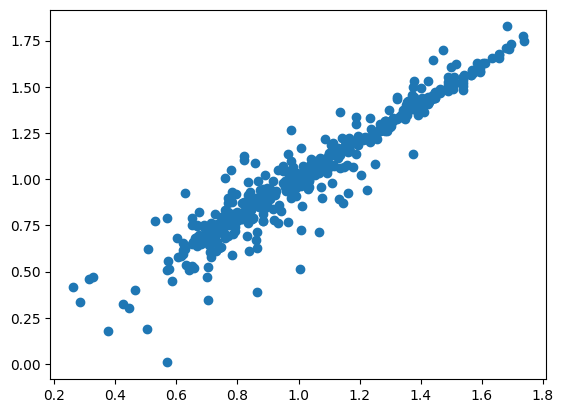

In [69]:
plt.scatter(y_valid1, kernel_preds1, label="Band Gap")
plt.scatter(preds2, y_valid2, color="red", label="Formation Energy")
plt.xlabel("Reference / eV")
plt.ylabel("Prediction / eV")
plt.legend()
plt.show()

How can we do the same using a deep learning approach? First, we have to specify how our neural network is structured. For convenience, this can be done using a simple functions whihc helps to set up the strcture of the network. Take a look at the function and see how the number of input and output values is specified. Which parameters can we choose freely?

In [71]:
def generate_NN(n_layers, n_features, n_input, n_output, activation, optimizer, loss="mean_squared_error", reg=0.0):
    """
    Basic template to generate a deep neural network with uniform number of features, activation etc.
    ### Inputs ###
    n_layers: defining the total number of dense layers, int
    n_features: Number of perceptrons per layer, int
    n_output: Number of input features, int
    n_output: Number of output features, int
    activation: Activation function applied in each layer
    Optional: loss function, optimizer
    ### Output ###
    nn: Keras Neural Network
    """
    from keras.models import Sequential 
    from keras.layers import Dense, BatchNormalization
    from keras.regularizers import L2
    
    nn = Sequential()
    for i in range(n_layers):
        if i == 1:
            nn.add(Dense(n_features, input_dim=n_input, activation=activation, kernel_regularizer=L2(reg)))
            nn.add(BatchNormalization())
        elif i > 1:
            nn.add(Dense(n_features, input_dim=n_features, activation=activation, kernel_regularizer=L2(reg)))
            nn.add(BatchNormalization())

    nn.add(Dense(n_output, input_dim=n_input))
    nn.compile(loss=loss, optimizer=optimizer)
    return nn

As a starting point, we use a shallow NN with only a single hidden layer.

In [96]:
# NN Parameter
n_features = 16
n_layers = 2
learning_rate = 0.01
regularization = 0.0001
activation = "sigmoid"
iterations = 100
batch_size = 20
input_features = features_df.shape[-1]

The second ingredient for a NN approach is the optimizer for the stochastic optimization. As a starting point, we use the plain stochastic gradient descent algorithm for the optimization. 

In [97]:
optimizer = keras.optimizers.SGD(learning_rate=learning_rate) 
model = generate_NN(n_layers, n_features, input_features, 2, activation, optimizer, reg=regularization)

In difference to a Kernel regression approach, we can predict both properties for a single model! In difference to a deterministic approach, a stochastic optimization can go on and on and on and on. Therefore we have to specify a stopping criterion, for example a maximum number of iterations. Here, we train for 100 iterations.

In [98]:
X_train, X_valid, y_train, y_valid = train_test_split(features_df, Targets_df, test_size=0.2, random_state=2017)
output = model.fit(np.array(X_train).astype('float32'), np.array(y_train).astype('float32'), epochs=iterations, batch_size=batch_size)

Epoch 1/200
96/96 [==============================] - 1s 2ms/step - loss: 0.6435
Epoch 2/200
96/96 [==============================] - 0s 2ms/step - loss: 0.1536
Epoch 3/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0735
Epoch 4/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0559
Epoch 5/200
96/96 [==============================] - 0s 1ms/step - loss: 0.0460
Epoch 6/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0403
Epoch 7/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0363
Epoch 8/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0338
Epoch 9/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0305
Epoch 10/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 11/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0264
Epoch 12/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0238
Epoch 13/200
96/96 [=================

Lets see how our model performs on the test set:

In [100]:
pred = model.predict(np.array(X_valid, dtype=np.float32))

y_valid1 = np.array(y_valid)[:, 0]
y_valid2 = np.array(y_valid)[:, 1]
nn_preds1 = pred[:, 0]
nn_preds2 = pred[:, 1]
rsme_valid1 = np.sqrt(mean_squared_error(y_valid1,nn_preds1))
rsme_valid2 = np.sqrt(mean_squared_error(y_valid2,nn_preds2))

rsme_total = np.sqrt(rsme_valid1*rsme_valid1+rsme_valid2*rsme_valid2)
print('RSME for formation energy:')
print(rsme_valid1)
print('RSME for band gap:')
print(rsme_valid2)
print('RSME for total:')
print(rsme_total)

15/15 [==============================] - 0s 883us/step
RSME for formation energy:
0.08899898000193855
RSME for band gap:
0.03478438471808113
RSME for total:
0.09555507240121236


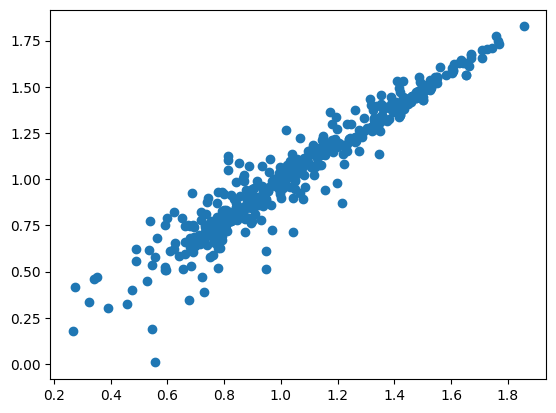

In [101]:
plt.scatter(y_valid1, nn_preds1, label="Formation Energy")
plt.scatter(y_valid2, nn_preds2, label="Band Gap", color="red")
plt.xlabel("Reference / eV")
plt.ylabel("Prediction / eV")
plt.legend()
plt.show()

What can we do to further boost the performance of our models? If you have a look at out input data, you'll see that the amount of information we provide is very limited, and in addition we use only a small dataset. Partially, this can be fixed by providing additional information to our model as input features. But where does this data come from? Fortunately, the dataset comprises not only the data we used so far, but in addition the structural data of all compounds. This means, in addition to the provided data we can increase the amount of information by extracting chemical relevant informations from the files. Below are several ideas how to do this, feel free to extend it by your own method. Note that all of the function below rely on an "Atom" object from ASE, which is used to store the structural data. If you want to know more about this, you can read it up [here](https://wiki.fysik.dtu.dk/ase/ase/atoms.html).

In [78]:
def volume(atom):
    """
    Calculates the volume of a unit cell
    """
    return atom.get_volume()


def valence_d_electrons(atom):
    """
    Calculates the fraction of d electrons in the valence shell
    """
    Z = atom.get_atomic_numbers()
    n_d = np.sum((Z == 31) * 10 + (Z == 49) * 10) 
    n_v = np.sum((Z == 31) * 13 + (Z == 49) * 13 + (Z == 13) * 3 + (Z == 8) * 6)
    d_frac = n_d / n_v
    return d_frac

def mean_metal_distance(atom):
    """
    Calculates the mean distance between metal centres in the unit cell
    """
    pos = atom.positions
    Z = atom.get_atomic_numbers()
    metal_pos = pos[Z != 8]
    mean = 0
    N = metal_pos.shape[0]
    for i, pos1 in enumerate(metal_pos[:-1]):
        d = np.linalg.norm(metal_pos[(i + 1):] - pos1, axis=1)
        mean += np.sum(d) / (N - i - 1)
    return mean / (i)


def mean_oxygen_distance(atom):
    """
    Calculates the mean distance between metal centres in the unit cell
    """
    pos = atom.positions
    Z = atom.get_atomic_numbers()
    metal_pos = pos[Z != 8]
    oxygen_pos = pos[Z == 8]
    mean = 0
    N = metal_pos.shape[0]
    for i, pos1 in enumerate(oxygen_pos):
        d = np.linalg.norm(metal_pos - pos1, axis=1)
        mean += np.sum(d) / N
    return mean / (i + 1)

Using ASE, we now use the predefined functions to improve the quality of our input features. 

In [79]:
train_volume = np.zeros(train_df.shape[0])
train_d = np.zeros(train_df.shape[0])
train_m_dist = np.zeros(train_df.shape[0])
train_o_dist = np.zeros(train_df.shape[0])

for i in train_df.index:
    filename = f"train/{i+1}/geometry.xyz"
    atom = read_aims(filename)
    train_volume[i] = volume(atom)
    train_d[i] = valence_d_electrons(atom)
    train_m_dist[i] = mean_metal_distance(atom)
    train_o_dist[i] = mean_oxygen_distance(atom)

    # Feel free to add further properties here

features_df["Volume"] = (train_volume - train_volume.mean()) / train_volume.std()
features_df["d-Electrons"] = (train_d - train_d.mean()) / train_d.std()
features_df["MeanMDistance"] = (train_m_dist - train_m_dist.mean()) / train_m_dist.std()
features_df["MeanODistance"] = (train_o_dist - train_o_dist.mean()) / train_o_dist.std()
input_features = features_df.shape[-1]
optimizer = keras.optimizers.Adam(learning_rate=learning_rate) 
model = generate_NN(n_layers, n_features, input_features, 2, activation, optimizer, reg=regularization)

Lets see how this works: 

In [80]:
X_train, X_valid, y_train, y_valid = train_test_split(features_df, Targets_df, test_size=0.2, random_state=2017)
output = model.fit(np.array(X_train).astype('float32'), np.array(y_train).astype('float32'), epochs=iterations, batch_size=batch_size, callbacks=keras.callbacks.TensorBoard())

Epoch 1/200
96/96 [==============================] - 1s 2ms/step - loss: 0.7464
Epoch 2/200
96/96 [==============================] - 0s 3ms/step - loss: 0.1435
Epoch 3/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0495
Epoch 4/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0357
Epoch 5/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0300
Epoch 6/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0272
Epoch 7/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0241
Epoch 8/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0226
Epoch 9/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 10/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 11/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 12/200
96/96 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 13/200
96/96 [=================

In [81]:
pred = model.predict(np.array(X_valid, dtype=np.float32))
pred_train = model.predict(np.array(X_train, dtype=np.float32))
model.evaluate(np.array(X_valid, dtype=np.float32), np.array(y_valid, dtype=np.float32))
y_valid3 = np.array(y_valid)[:, 0]
y_valid4 = np.array(y_valid)[:, 1]
preds3 = pred[:, 0]
preds4 = pred[:, 1]
rsme_valid1 = np.sqrt(mean_squared_error(y_valid3,preds3))
rsme_valid2 = np.sqrt(mean_squared_error(y_valid4,preds4))

rsme_total = np.sqrt(rsme_valid1*rsme_valid1+rsme_valid2*rsme_valid2)
print('RSME for formation energy:')
print(rsme_valid1)
print('RSME for band gap:')
print(rsme_valid2)
print('RSME for total:')
print(rsme_total)

15/15 [==============================] - 0s 1ms/step - loss: 0.0056
RSME for formation energy:
0.09021606555528368
RSME for band gap:
0.03636881398536503
RSME for total:
0.0972709057990997


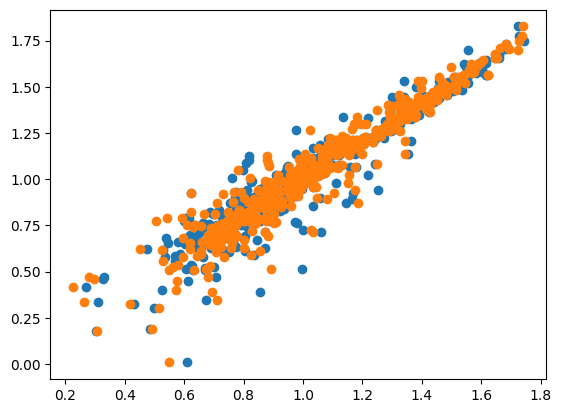

In [82]:
plt.scatter(preds1, y_valid1)
plt.scatter(preds3, y_valid3)

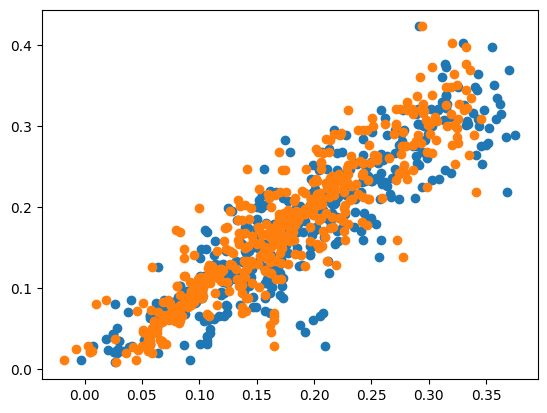

In [83]:
plt.scatter(preds2, y_valid2)
plt.scatter(preds4, y_valid4)